# Report 01: Applied Deep Learning

## Cooper Simpson

In [ ]:
%%capture
jt -r

In [1]:
#Change theme
from jupyterthemes import jtplot
!jt -t grade3
jtplot.style()

This report will re-examine some of the topics related to Convolutional Neural Networks (CNN's) discussed in class. Guiding information comes from chapters 6 and 7 of [*Dive Into Deep Learning*](http://d2l.ai/chapter_convolutional-neural-networks/index.html), and we will follow the same general flow. Important aspects and details will be summarized and expanded upon, with some basic coding exercises at the end to cement ideas. Not every detail will be included, but instead the focus will be on information that I felt could use further exploration.

## What is a Convolution?

Outside of the realm of Deep Learning and CNN's, a convolution is an operator on two functions with a precise mathematical definition.

$$
(f*g)(x) = \int f(z)\cdot g(x-z)dz
$$

This operation is essentially blending the two functions together as $g$ is flipped and slid across $f$. This process can also be extended to discrete functions where the integral is replaced with a sum, or to multidimensional functions. Looking ahead to images (the focus for CNN's) which are expressed as tensors, the convolution for such a two-dimensional tensor (excluding channels) is given below.

$$
(f*g)(i,j) = \sum_a\sum_bf(a,b)\cdot g(i-a,j-b)
$$

The question now is how all of this relates to the convolution process used in CNN's? Given some input tensor $\mathbf{I}$ that we will assume is a single channel image, a convolution layer produces an ouput $\mathbf{P}$ according to the following process:

$$
\mathbf{P}_{i,j} = \sum_{a=-\epsilon}^{\epsilon}\sum_{b=-\epsilon}^{\epsilon}\mathbf{F}_{a,b}\mathbf{I}_{i+a.j+b}
$$

Here $\mathbf{F}$ is the filter being applied and $\epsilon\in\mathbb{N}$ is the size of the filter -- note we have also omitted the bias term. We can see a few differences between the process actually being applied in a convolutional layer and the definition of a discrete convolution. Specifically, we note that the range of the sums are restricted and the indexing is using addition (i.e. $(i+a)$) instead of subtraction (i.e. $(i-a)$). The restricted sums can be explained away by one of the two major ideas behind convolution layers, the principle of locality. Essentially, this says that data in the image (i.e. pixels) should have a limited spatial dependence on the data around them. This is why the sums only look in an $\epsilon$ region around $(a,b)$ as that is considered the only important region. The indexing change on the other hand is because the convolution layer is actually computing a cross-correlation -- which is closely related to a convolution. In our image case the cross-correlation is actually equivalent to the convolution, but with a transposed filter $\mathbf{F}$. Because of the way deep learning works this isn't a problem as training from data will learn the filter it needs to learn regardless of how we define things.

## Convolutional Neural Networks

Having established how a convolutional layer relates to an actual convolution, we can move on to some specifics about the inner workings of a CNN. We start by asking why one should use this method and what it means? A simple answer to the first question is that empirically it works very well. This is not entirely a huge surprise as some of the inspiration for CNN's came from neurobiological processes in the brain. Groups of visual receptors do feature detection just like filters and layers in a CNN. Eariler we touched on the two major guiding principles of convolutional layers. The first was the idea of locality and a limited spatial dependence. The second is translation invariance. This means that given some feature in an arbitrary location the network should activate in an equivalent manner. If we are looking for horizontal lines than it shouldn't matter where they are located in the image, but just that they are there. In application this is achieved by using a static filter and bias that don't depend on the location. It is suprising how such an effective method as convolution can be created based on a few good observations about a particular piece of data (images). That isn't to say that convolutional layers can't be applied to other data, but just that putting some thought into it can go a long way. 

A convolution layer works by sliding a filter across and down an image to compute an output based on the element wise product of the filter and the pixels from the image. For this general process with a $(i_h,\;i_w)$ image and a $(f_h,\;f_w)$ filter, the output shape is given as...

$$((i_h-f_h+1),\;(i_w-f_w+1))$$

However, this somewhat ignores a key aspect of images and of the data as it is processed deeper into a network. Namely, the channels (i.e. red, green, and blue in a color image), which make up the third dimension (for images) of an input tensor in a convolutional layer. In reality the channels are easy to deal with. It only requires each point of the filter to be of the same channel dimension (i.e. three for a color image) so that each element-wise product in the convolution is actually a dot product of vectors. This makes a filter itself a three dimensional tensor, and keeps the output as a two dimensional tensor. Initially, that may seem like a large reduction in complexity (eliminating a whole dimension). In practice, however, multiple filters are used at each convolutional layer to maintain multiple channels. If three filters were used then there would be three channels in the output. The remaining dimensions of the output are determined by a number of things which includes the dimension of the filter and a few other important parameters discussed next.

### Padding and Stride

Given that any filter of size greater than one will reduce the width and height dimensionality of an input we may ask if there is a way to prevent this? Furthermore, given the mechanism by which a convolution works (i.e. sliding along the input) we may ask what about the edges, or how far do you slide? Because only patches of the input that fit exactly in the filter will be processed, after a few iterations the dimensionality can be greatly reduced and a lot of information lost. This is where padding and stride come in. Padding increases the dimensionality of the input by inserting rows and columns of zeros around the initial input. Without this there will never be a case where the filter is centered on a corner or edge, thus giving more emphasis to the interior data. Striding changes the number of columns or rows that are shifted across when filtering over an image. In the general case the stride is one, and the filter shifts one column or row each time it moves. This can be redundant and striding also gives one the ability to reduce dimensionality. Incorporating this information we have the following new formula for the output shape where we have reused the image and filter notation, the padding shape is $(p_h,\;p_w)$, and the stride shape is $(s_h,\;s_w)$:

$$(\lfloor\frac{i_h-f_h+p_h+s_h}{s_h}\rfloor,\;\lfloor\frac{i_w-f_w+p_w+s_w}{s_w}\rfloor)$$

This gives rise to an interesting result where typical convolution filters are of odd dimension (i.e. (5,5), (11,11)). This allows one to maintain the original dimension and use symmetrical padding around the input.

On the topic of dimensionality handling we may also mention (1,1) convolutions. This is simply a filter of unit size so that it only applies to one pixel at a time. In effect this is the same as applying a dense layer to every pixel individually. It is extremely useful for reducing the complexity of the input by controlling the number of channels.

### Pooling

We have discussed some methods for controlling dimensionality, but mostly on the end of maintaining it. Eventually, somewhere down the line in a neural network the dimensionality will need to be reduced to get some sort of meaningful output. In practice this is done progressively, resulting in an increase in coarseness and a more global perspective deeper in the network. Pooling layers serve exactly this purpose and are functionally quite similar to convolutions. There are two main types: max pooling and average pooling, with global average pooling being a common instantiation of the latter. Just like with convolutions pooling uses a sliding window, and then computes the maximum or the average of the data it is covering. Also like a convolutional layer, padding can be added and the stride can be altered to change the dimensionality beyond the operation it is performing. However, unlike convolutions pooling does not consider the channel dimension all at once. Instead it performs the operation across each channel meaning that dimension is preserved. Pooling also makes the network more robust to translation in the data. Because you are looking at some window it doesn't matter if the data is somewhat shifted from what has been seen before as long as it is still in the window. As mentioned before, global average pooling is a subset of average pooling where the filter covers the entire height and width of the data. This is considerably useful as a final step to obtain a one dimensional tensor for classification.

## Coding Exercises

Here we will perform a few basic convolutions with pre-made filters.

In [27]:
import numpy as np

#Simple function to convolve the filter F along an image I
def conv2d(I, F):
    h, w = F.shape
    P = np.zeros((I.shape[0]-h+1, I.shape[1]-w+1))
    
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            P[i,j] = np.multiply(I[i:i+h, j:j+w], F).sum()
            
    return P

In [28]:
#Sobel edge matrices
#Lx is for horizontal lines, and Ly is for vertical lines

L_y = np.array([[1, 0, -1],
                [2, 0, -2],
                [1, 0, -1]])

L_x = L_y.T

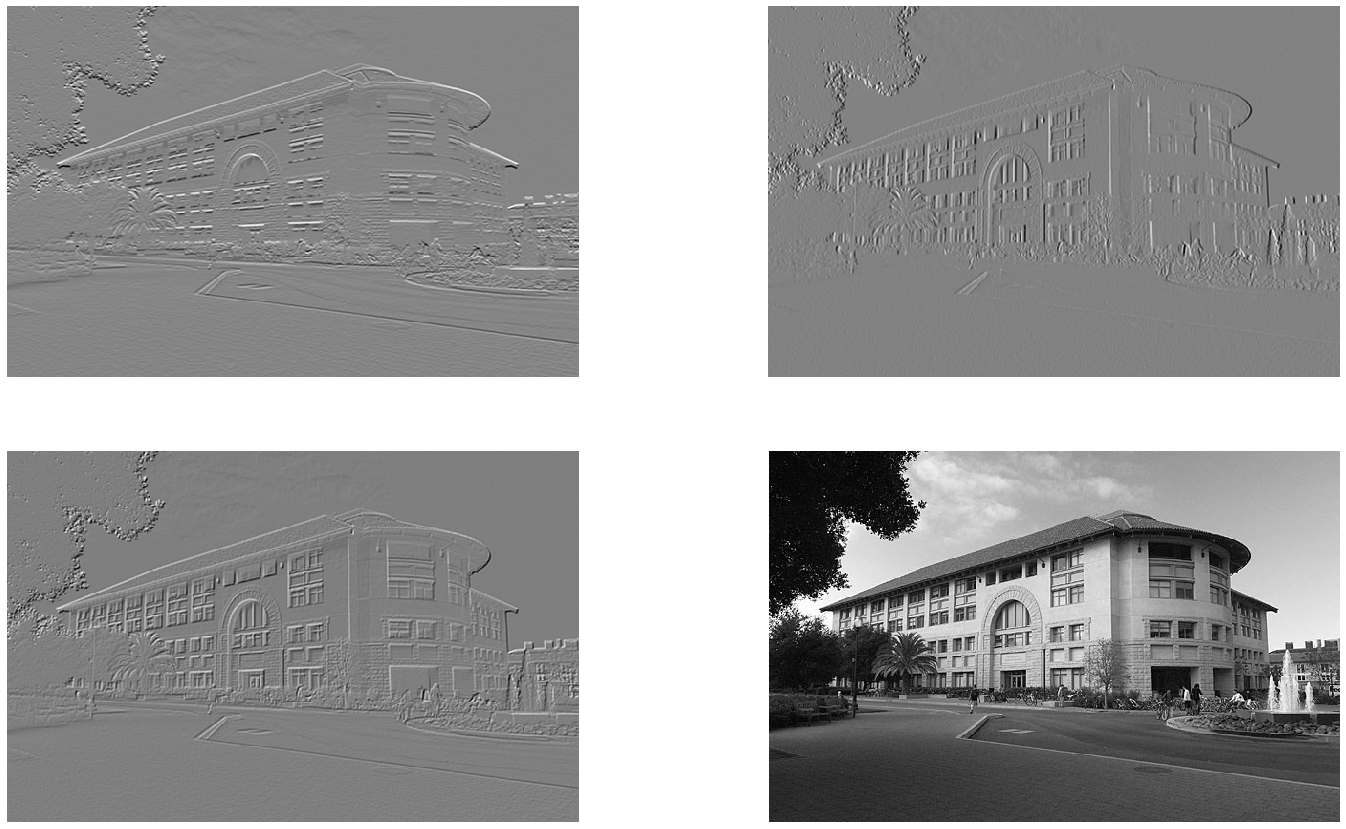

In [48]:
from matplotlib import image, pyplot

image = image.imread('building.png')
# print(image.shape)

horizontal = conv2d(image, L_x)
vertical = conv2d(image, L_y)

total = horizontal+vertical

fig, ax = pyplot.subplots(2,2, figsize=(25,15))

ax[0,0].imshow(horizontal, cmap='gray')
ax[0,1].imshow(vertical, cmap='gray')
ax[1,0].imshow(total, cmap='gray')
ax[1,1].imshow(image, cmap='gray')

for a in ax:
    a[0].axis('off')
    a[1].axis('off')

In the above images we see the result of the horizontal line filter in the top left, the vertical line filter in the top right, the total in the bottom left, and the original image in the bottom right. While what we have done here does not come all that close to the scale of a true CNN, we do capture the main idea of a convolution. In reality the filters would be learned from data and may or may not be all that interpertable. As well, there would be many more layers with more complexity. However, we do see what a convolution layer is doing in a general sense and how that can be useuful.